In [1]:
import mlplol
import numpy as np
import matplotlib.pyplot as plt
import sklearn.datasets

We will use the diabetes regression dataset from sklearn.

In [2]:
diabetes = sklearn.datasets.load_diabetes()

def split_data_np(features, target, validation_fraction, test_fraction):
    N = features.shape[0]
    inds_shuffled = np.random.permutation(np.arange(0, N))
    train_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction - validation_fraction)))
    val_thresh = int(np.round(inds_shuffled.shape[0] * (1 - test_fraction)))
    train_inds = inds_shuffled[0:train_thresh]
    val_inds = inds_shuffled[train_thresh:val_thresh]
    test_inds = inds_shuffled[val_thresh:]

    trainX = features[train_inds, :]
    trainY = target[train_inds]

    valX = features[val_inds, :]
    valY = target[val_inds]

    testX = features[test_inds, :]
    testY = target[test_inds]

    return dict(trainx=trainX, trainy=trainY, valx=valX, valy=valY, testx=testX, testy=testY)


diabetes_split = split_data_np(diabetes.data, diabetes.target, 0.2, 0.2)

In [3]:
# check the shape
diabetes.data.shape

(442, 10)

We can check that the gradient is correct by making up some weights and checking the computed gradient vs the gradient computed with the finite difference method.

In [4]:
# make some test weights
D_test = 6
wtest1 = np.random.normal(0, 1, (diabetes.data.shape[1]+1, D_test))
wtest2 = np.random.normal(0, 1, (D_test+1, 1))

test_nn_outputs = mlplol.neural_network(diabetes_split['trainx'], [wtest1, wtest2], 'relu')

x_with_biascol = np.c_[np.ones(diabetes_split['trainx'].shape[0]), diabetes_split['trainx']]
y_2dim = np.expand_dims(diabetes_split['trainy'], axis=1)

true_gradient = mlplol.nn_grad(x_with_biascol, y_2dim, test_nn_outputs['a1'], test_nn_outputs['z1'], 
                               test_nn_outputs['output'], [wtest1, wtest2], 'relu')

true_squared_error = mlplol.squared_loss(y_2dim, test_nn_outputs['output'])

eps = np.sqrt(np.finfo(float).eps) # this is a very small number

finite_difference_grad = mlplol.calc_approx_grad([wtest1, wtest2], diabetes_split['trainx'], y_2dim, 
                                                 eps, true_squared_error, 'relu')

print([(i+eps)/(j+eps) for i,j in zip(true_gradient, finite_difference_grad)]) 
# we added eps again in the final gradients in order to avoid dividing by zero

[array([[0.99999855, 0.99999914, 0.99999958, 1.        , 0.99994018,
        1.00000056],
       [1.00046215, 0.99982888, 0.99989155, 1.        , 1.00538343,
        0.99999948],
       [1.00235016, 0.99985038, 0.99965719, 1.        , 0.99762984,
        1.0006056 ],
       [1.00018217, 1.00000314, 0.99998847, 1.        , 0.99736734,
        1.00002005],
       [1.00000537, 0.99984565, 0.99996474, 1.        , 1.0016193 ,
        1.00002266],
       [1.00013015, 0.99962288, 0.99983625, 1.        , 0.99724017,
        0.99997428],
       [0.99997724, 0.99991934, 0.9997825 , 1.        , 0.99776551,
        1.00020687],
       [1.00005869, 1.00007592, 0.99998068, 1.        , 1.00145097,
        0.99999534],
       [1.00007843, 0.99983856, 0.99997658, 1.        , 0.99894336,
        1.00003055],
       [1.00012201, 1.00003197, 0.99997093, 1.        , 1.00015935,
        1.00001637],
       [1.00002082, 0.99989096, 0.99998967, 1.        , 0.9973233 ,
        1.00003756]]), array([[1.00000035

In [5]:
# output shapes
test_nn_outputs['output'].shape

(265, 1)

We train a model and visualize the training and validation loss during training. It just uses regular gradient descent with all the datapoints in each iteration.

In [6]:
diabetes_nn = mlplol.NNregressor_onelayer(activation_function = 'relu')
diabetes_nn.estimate_weights(diabetes_split['trainx'], diabetes_split['trainy'], diabetes_split['valx'],
                             diabetes_split['valy'], n_hidden=100,
                              iterations=100, patience=10, rate=0.001,
                              verbose=False, weight_initialization_factors=None)

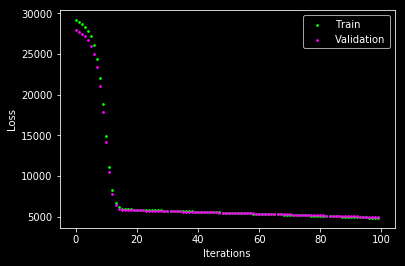

In [7]:
plt.style.use("dark_background")
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(diabetes_nn.iterations), diabetes_nn.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

Check test loss

In [8]:
test_pred = diabetes_nn.predict(diabetes_split['testx'])
test_loss = mlplol.squared_loss(test_pred, diabetes_split['testy'])
print('test loss: ', test_loss)

test loss:  4781.163569518242


Since we can output to any dimension we can try making a very simple autoencoder. We use two hidden units and compare the dimensionality reduction to PCA.

In [9]:
iris = sklearn.datasets.load_iris()

In [10]:
iris.data.shape

(150, 4)

In [11]:
iris_split = split_data_np(iris.data, iris.target, 0.2, 0.2)

In [12]:
iris_ae = mlplol.NNregressor_onelayer(activation_function = 'softsign')
iris_ae.estimate_weights(iris_split['trainx'], iris_split['trainx'], iris_split['valx'],
                             iris_split['valx'], n_hidden=2, 
                              iterations=10000, patience=10, rate=0.001, 
                              verbose=False, weight_initialization_factors=None)

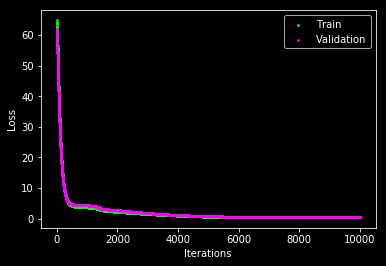

In [13]:
plt.style.use("dark_background")
plt.scatter(np.arange(iris_ae.iterations), iris_ae.training_loss, s=3, c='lime', label='Train')
plt.scatter(np.arange(iris_ae.iterations), iris_ae.validation_loss, s=3, c='fuchsia', label='Validation')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.legend(loc='upper right')
plt.show()

In [14]:
test_reconstructions = iris_ae.predict(iris_split['testx'])
test_loss_ae = mlplol.squared_loss(iris_split['testx'], test_reconstructions)
print('test loss post train: ', test_loss_ae)

test loss post train:  0.38966217173595824


In [15]:
iris_code = iris_ae.encode(iris.data)

In [16]:
iris_code.shape

(150, 2)

In [17]:
from sklearn.decomposition import PCA

In [18]:
pca = PCA(n_components=2)
pca.fit(iris.data)
iris_pca = pca.transform(iris.data)

Visualizing the dimensionality reductions.

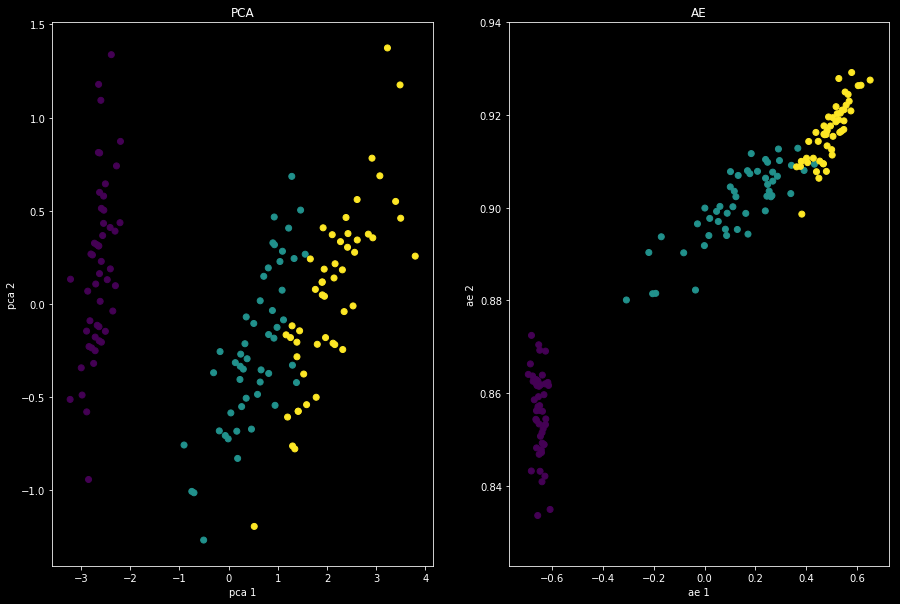

In [19]:
plt.style.use("dark_background")
fig, ax = plt.subplots(1, 2, figsize=(15,10))
ax[0].scatter(iris_pca[:, 0], iris_pca[:, 1], c=iris.target)
ax[0].set_xlabel('pca 1')
ax[0].set_ylabel('pca 2')
ax[0].set_title('PCA')

ax[1].scatter(iris_code[:, 0], iris_code[:, 1], c=iris.target)
ax[1].set_xlabel('ae 1')
ax[1].set_ylabel('ae 2')
ax[1].set_title('AE')

plt.show()

The neural network does indeed learn a similar space, preserving the overall distance relations between the classes.